In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import re, copy
from scipy.stats import poisson
from sklearn.metrics import log_loss

SEASON_SPLIT = 2024

## Reading in data from csv files

In [2]:
matches = pd.read_csv('matches.csv', index_col=0)
print(matches.shape)

(2848, 40)


In [3]:
next_matches = pd.read_csv('next_matches.csv', index_col=0)
print(next_matches.shape)

(20, 22)


In [4]:
history_matches = pd.read_csv('history.csv', index_col=0)
print(history_matches.shape)

(19451, 16)


In [5]:
# getting the matches of the desired league
LEAGUE = 'La Liga'
league_matches = matches[matches['Comp'] == LEAGUE]
league_history_matches = history_matches[history_matches['Comp'] == LEAGUE]
league_matches.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,2CrdY,Fls,Fld,Off,Crs,Int,TklW,Won%,SCA,GCA
0,2025-08-19,21:00 (05:00),La Liga,Matchweek 1,Tue,Home,W,1,0,Osasuna,...,0.0,10.0,12.0,0.0,19.0,6.0,10.0,46.2,34.0,2.0
1,2025-08-24,21:30 (05:30),La Liga,Matchweek 2,Sun,Away,W,3,0,Oviedo,...,0.0,7.0,7.0,2.0,15.0,9.0,17.0,58.8,49.0,5.0
2,2025-08-30,21:30 (05:30),La Liga,Matchweek 3,Sat,Home,W,2,1,Mallorca,...,0.0,12.0,6.0,3.0,14.0,7.0,8.0,54.2,33.0,3.0
3,2025-09-13,16:15 (00:15),La Liga,Matchweek 4,Sat,Away,W,2,1,Real Sociedad,...,0.0,7.0,17.0,2.0,8.0,10.0,5.0,60.6,30.0,3.0
5,2025-08-16,19:30 (03:30),La Liga,Matchweek 1,Sat,Away,W,3,0,Mallorca,...,0.0,17.0,8.0,3.0,10.0,7.0,10.0,70.6,46.0,5.0


## Date Exploration and Analysis

In [6]:
league_matches['Team'].value_counts()

Team
Real Betis         120
Celta Vigo         119
Real Sociedad      119
Athletic Club      118
Barcelona          118
Villarreal         118
Osasuna            118
Sevilla            118
Getafe             118
Real Madrid        118
Rayo Vallecano     118
Valencia           118
Girona             118
Atletico Madrid    118
Mallorca           118
Espanyol            80
Alaves              80
Almeria             76
Las Palmas          76
Cadiz               76
Valladolid          76
Elche               42
Leganes             38
Granada             38
Levante              4
Oviedo               4
Name: count, dtype: int64

In [7]:
league_matches['Opponent'].value_counts()

Opponent
Betis              120
Real Sociedad      119
Celta Vigo         119
Mallorca           118
Atlético Madrid    118
Valencia           118
Sevilla            118
Athletic Club      118
Rayo Vallecano     118
Osasuna            118
Barcelona          118
Real Madrid        118
Villarreal         118
Getafe             118
Girona             118
Espanyol            80
Alavés              80
Valladolid          76
Almería             76
Cádiz               76
Las Palmas          76
Elche               42
Leganés             38
Granada             38
Levante              4
Oviedo               4
Name: count, dtype: int64

In [8]:
league_matches.dtypes

Date              object
Time              object
Comp              object
Round             object
Day               object
Venue             object
Result            object
GF                object
GA                object
Opponent          object
xG               float64
xGA              float64
Poss             float64
Attendance       float64
Captain           object
Formation         object
Opp Formation     object
Referee           object
Match Report      object
Notes             object
Season             int64
Team              object
Sh               float64
SoT              float64
Dist             float64
FK               float64
PK               float64
PKatt            float64
CrdY             float64
CrdR             float64
2CrdY            float64
Fls              float64
Fld              float64
Off              float64
Crs              float64
Int              float64
TklW             float64
Won%             float64
SCA              float64
GCA              float64


In [9]:
team_names = sorted(league_matches['Team'].unique())
opp_names = sorted(league_matches['Opponent'].unique())

exculsive_team_names = []
exculsive_opp_names = []

# finding out the team names that are written differently in the opponent column
for i in team_names:
    if (i not in opp_names):
        exculsive_team_names.append(i)
        print(i)

print('---------------------------')

for i in opp_names:
    if (i not in team_names):
        exculsive_opp_names.append(i)
        print(i)

Alaves
Almeria
Atletico Madrid
Cadiz
Leganes
Real Betis
---------------------------
Alavés
Almería
Atlético Madrid
Betis
Cádiz
Leganés


In [10]:
exculsive_team_names.remove('Real Betis')
exculsive_team_names.append('Real Betis')
exculsive_opp_names.remove('Betis')
exculsive_opp_names.append('Betis')

In [11]:
# creating class to map team names written differently in opponent column to 
# corresponding team names.
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {}

for team_name, opp_name in zip(exculsive_team_names, exculsive_opp_names):
    map_values[team_name] = opp_name

mapping = MissingDict(**map_values)

In [12]:
map_values

{'Alaves': 'Alavés',
 'Almeria': 'Almería',
 'Atletico Madrid': 'Atlético Madrid',
 'Cadiz': 'Cádiz',
 'Leganes': 'Leganés',
 'Real Betis': 'Betis'}

In [13]:
# applying mapping to ensure consistent team names
matches['Team'] = matches['Team'].map(mapping)
# creating a dictionary of team codes to ensure consistent team codes for each
# team
team_mapping_dict = {key: value for key, value in zip(matches['Team'], matches['Team'].astype('category').cat.codes)}
matches['Team_code'] = matches['Team'].map(team_mapping_dict)
matches['Opp_code'] = matches['Opponent'].map(team_mapping_dict)

# simplifying date and venue into respective codes
matches['Date'] = pd.to_datetime(matches['Date'])
matches['Venue_code'] = matches['Venue'].astype('category').cat.codes
matches['Hour'] = matches['Time'].str.replace(":.+", "", regex=True).astype('int')
matches['Day_code'] = matches['Date'].dt.dayofweek

matches['Target'] = matches['Result'].astype('category').cat.codes

matches['GF'] = matches['GF'].apply(lambda x: int(re.search(r'^[0-9]+', x).group(0)))
matches['GA'] = matches['GA'].apply(lambda x: int(re.search(r'^[0-9]+', x).group(0)))

In [14]:
matches.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,TklW,Won%,SCA,GCA,Team_code,Opp_code,Venue_code,Hour,Day_code,Target
0,2025-08-19,21:00 (05:00),La Liga,Matchweek 1,Tue,Home,W,1,0,Osasuna,...,10.0,46.2,34.0,2.0,20,17.0,1,21,1,2
1,2025-08-24,21:30 (05:30),La Liga,Matchweek 2,Sun,Away,W,3,0,Oviedo,...,17.0,58.8,49.0,5.0,20,18.0,0,21,6,2
2,2025-08-30,21:30 (05:30),La Liga,Matchweek 3,Sat,Home,W,2,1,Mallorca,...,8.0,54.2,33.0,3.0,20,16.0,1,21,5,2
3,2025-09-13,16:15 (00:15),La Liga,Matchweek 4,Sat,Away,W,2,1,Real Sociedad,...,5.0,60.6,30.0,3.0,20,21.0,0,16,5,2
4,2025-09-16,21:00 (05:00),Champions Lg,League phase,Tue,Home,W,2,1,fr Marseille,...,8.0,29.4,43.0,3.0,20,NaN,1,21,1,2


In [15]:
# removing columns that are of no importance or repeated
matches = matches.drop(columns=['Time', 'Day', 'Result', 'Attendance',
                                'Match Report', 'Notes','Captain', 'Formation',
                                'Opp Formation', 'Referee'])

In [16]:
matches.dtypes

Date          datetime64[ns]
Comp                  object
Round                 object
Venue                 object
GF                     int64
GA                     int64
Opponent              object
xG                   float64
xGA                  float64
Poss                 float64
Season                 int64
Team                  object
Sh                   float64
SoT                  float64
Dist                 float64
FK                   float64
PK                   float64
PKatt                float64
CrdY                 float64
CrdR                 float64
2CrdY                float64
Fls                  float64
Fld                  float64
Off                  float64
Crs                  float64
Int                  float64
TklW                 float64
Won%                 float64
SCA                  float64
GCA                  float64
Team_code              int64
Opp_code             float64
Venue_code              int8
Hour                   int64
Day_code      

In [17]:
# encoding for next matches
next_matches['Team'] = next_matches['Team'].map(mapping)
next_matches['Team_code'] = next_matches['Team'].map(team_mapping_dict)
next_matches['Opp_code'] = next_matches['Opponent'].map(team_mapping_dict)

next_matches['Date'] = pd.to_datetime(next_matches['Date'])
next_matches['Venue_code'] = next_matches['Venue'].astype('category').cat.codes
next_matches['Hour'] = next_matches['Time'].str.replace(":.+", "", regex=True).astype('int')
next_matches['Day_code'] = next_matches['Date'].dt.dayofweek

In [18]:
next_matches = next_matches.drop(columns=['Time', 'Day', 'Venue', 'Result', 
                                          'Attendance', 'Match Report', 'Notes',
                                          'Captain', 'Formation',
                                          'Opp Formation', 'Referee'])

In [19]:
next_matches.dtypes

Date          datetime64[ns]
Comp                  object
Round                 object
GF                   float64
GA                   float64
Opponent              object
xG                   float64
xGA                  float64
Poss                 float64
Season                 int64
Team                  object
Team_code              int64
Opp_code               int64
Venue_code              int8
Hour                   int64
Day_code               int32
dtype: object

In [20]:
# function to get the Target value based on GF and GA
def get_Target(row):
    if row['GF'] > row['GA']:
        return 2
    elif row['GF'] < row['GA']:
        return 1
    else:
        return 0

In [21]:
# encoding for history matches
history_matches['Team'] = history_matches['Team'].map(mapping)
history_matches['Home'] = history_matches['Home'].map(mapping)
history_matches['Away'] = history_matches['Away'].map(mapping)
history_matches['Date'] = pd.to_datetime(history_matches['Date'])
history_matches['GF'] = history_matches['Score'].apply(lambda score: (score.split('–')[0]))
history_matches['GA'] = history_matches['Score'].apply(lambda score: score.split('–')[1])
history_matches['GF'] = history_matches['GF'].apply(lambda x: int(re.search(r'[0-9]+$', x).group(0)))
history_matches['GA'] = history_matches['GA'].apply(lambda x: int(re.search(r'^[0-9]+', x).group(0)))
history_matches['Target'] = history_matches.apply(get_Target, axis=1)

# ensuring consistent team and Opponent column across dataframes
for index, row in history_matches.iterrows():
    if row['Team'] == row['Away']:
        temp = row['Home']
        history_matches.loc[index, 'Home'] = row['Away']
        history_matches.loc[index, 'Away'] = temp
        temp = row['GF']
        history_matches.loc[index, 'GF'] = row['GA']
        history_matches.loc[index, 'GA'] = temp

history_matches['Opponent'] = history_matches['Away']

In [22]:
history_matches = history_matches.drop(columns=['Time', 'Day', 'Venue', 
                                                'Attendance', 
                                                'Notes', 'Referee',
                                                'Home', 'Away'])

In [23]:
history_matches.dtypes

Comp                    object
Round                   object
Date            datetime64[ns]
xG                     float64
Score                   object
xG.1                   float64
Match Report            object
Team                    object
GF                       int64
GA                       int64
Target                   int64
Opponent                object
dtype: object

In [24]:
# function to compute rolling averages of given columns for each match
def rolling_avgs(group, cols, new_cols, num_past_matches_considered=3):
    group = group.sort_values('Date')
    # not considering the current match and must have at least 1 match to calculate
    rolling_stats = group[cols].rolling(num_past_matches_considered, 
                                        closed='left', min_periods=1).mean()
    group[new_cols] = rolling_stats.fillna(0)
    return group

In [25]:
# rolling avgs for matches across the desired league
league_ravg_cols = ['GF', 'GA', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 
             'CrdR', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%',
             'SCA', 'GCA', 'xG', 'xGA']
league_ravg_new_cols = [f"{c}league_rolling" for c in league_ravg_cols]

In [26]:
# stats for last match
last_ravg_cols = ['GF', 'GA', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 
             'CrdR', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%',
             'SCA', 'GCA', 'xG', 'xGA', 'Target']
last_ravg_new_cols = [f"{c}last_rolling" for c in last_ravg_cols]

In [27]:
# rolling avgs for matches across all head to head matches
hth_ravg_cols = ['xG', 'xG.1', 'GF', 'GA']
hth_ravg_new_cols = [f"{c}hth_rolling" for c in hth_ravg_cols]

In [28]:
# function to compute rolling average of rest days for each match
def rolling_avg_match_rest(group, num_past_matches_considered=3):
    group = group.sort_values('Date')
    group['days_diff'] = group['Date'].diff().dt.days
    rolling_stats = group['days_diff'].rolling(num_past_matches_considered, 
                                        min_periods=1).mean()
    group[f'rolling_rests_{num_past_matches_considered}'] = rolling_stats.fillna(0)
    return group

In [29]:
# function to compute rolling number of wins for each match
def rolling_match_results(group, name, num_past_matches_considered=3):
    group = group.sort_values('Date')
    group['is_win'] = (group['Target'] == 2).astype(int)
    rolling_stats = group['is_win'].rolling(num_past_matches_considered, 
                                        closed='left', min_periods=1).sum()
    group[f'{name}num_wins_rolling'] = rolling_stats.fillna(0)
    return group

In [30]:
all_matches = pd.concat([matches, next_matches])
# computing rolling average rest days for all matches
all_matches = all_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avg_match_rest(x),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
all_matches = all_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avg_match_rest(x,1),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)

# getting the rolling averages for all league matches
league_matches = all_matches[all_matches['Comp'] == LEAGUE]
team_league_matches = league_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avgs(x, league_ravg_cols, league_ravg_new_cols),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
team_league_matches = team_league_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_match_results(x, 'league'),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)

# getting the rolling averages for last match
team_last_matches = all_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avgs(x, last_ravg_cols, last_ravg_new_cols,1),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)

# getting the rolling averages for head to head history
hth_and_next_matches = pd.concat([history_matches, next_matches])
team_hth_matches = hth_and_next_matches.groupby(['Team', 'Opponent'], group_keys=True).apply(lambda x: rolling_avgs(x, hth_ravg_cols, hth_ravg_new_cols),
                                                                               include_groups=False).reset_index(level=0).reset_index(drop=True)

team_hth_matches = team_hth_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_match_results(x, 'hth'),
                                                                               include_groups=False).reset_index(level=0).reset_index(drop=True)


In [33]:
# getting a copy of the matches dataframes to prepare for merging of opponent stats
opp_team_league_matches = team_league_matches.copy()
opp_team_league_matches = opp_team_league_matches.add_prefix('Opp_')

opp_team_last_matches = team_last_matches.copy()
opp_team_last_matches = opp_team_last_matches.add_prefix('Opp_')

In [34]:
# Merging matches with their opponent stats
team_league_matches = team_league_matches.merge(opp_team_league_matches,
                                         left_on=['Date', 'Opponent'],
                                         right_on=['Opp_Date', 'Opp_Team'],
                                         how='left')
team_league_matches = team_league_matches.drop(columns=['Opp_Date', 'Opp_Team', 'Opp_Comp', 'Opp_Round',
                                  'Opp_GF', 'Opp_GA', 'Opp_Opponent','Opp_xG',
                                  'Opp_xGA', 'Opp_Season', 'Opp_Team_code', 'Opp_Opp_code',
                                  'Opp_Venue_code', 'Opp_Hour', 'Opp_Day_code',
                                  'Opp_Target', 'Opp_days_diff', 'Opp_is_win'])
team_last_matches = team_last_matches.merge(opp_team_last_matches,
                                         left_on=['Date', 'Opponent'],
                                         right_on=['Opp_Date', 'Opp_Team'],
                                         how='left')
team_last_matches = team_last_matches.drop(columns=['Opp_Date', 'Opp_Team', 'Opp_Comp', 'Opp_Round',
                                  'Opp_GF', 'Opp_GA', 'Opp_Opponent','Opp_xG',
                                  'Opp_xGA', 'Opp_Season', 'Opp_Team_code', 'Opp_Opp_code',
                                  'Opp_Venue_code', 'Opp_Hour', 'Opp_Day_code',
                                  'Opp_days_diff'])

In [35]:
# merging matches, next matches, head to head history dataframes together into one
last_ravg_new_cols_merge = copy.deepcopy(last_ravg_new_cols)
hth_ravg_new_cols_merge = copy.deepcopy(hth_ravg_new_cols)
last_ravg_new_cols_merge = last_ravg_new_cols_merge + ['Opp_' + column for column in last_ravg_new_cols_merge]
last_ravg_new_cols_merge.append('Date')
hth_ravg_new_cols_merge.append('Date')
last_ravg_new_cols_merge.append('Team')
hth_ravg_new_cols_merge.append('Team')
hth_ravg_new_cols_merge.append('hthnum_wins_rolling')
team_matches = team_league_matches.merge(team_last_matches[last_ravg_new_cols_merge],
                                                on=['Date', 'Team'], how='left')
team_matches = team_matches.merge(team_hth_matches[hth_ravg_new_cols_merge],
                                                on=['Date', 'Team'], how='left')

In [36]:
team_matches

,Team,Date,Comp,Round,Venue,GF,GA,Opponent,xG,xGA,...,Opp_SCAlast_rolling,Opp_GCAlast_rolling,Opp_xGlast_rolling,Opp_xGAlast_rolling,Opp_Targetlast_rolling,xGhth_rolling,xG.1hth_rolling,GFhth_rolling,GAhth_rolling,hthnum_wins_rolling
0,Alavés,2023-08-14,La Liga,Matchweek 1,Away,0.0,1.0,Cádiz,0.3,0.7,...,18.0,1.0,2.5,1.6,0.0,1.133333,1.533333,1.000000,0.666667,0.0
1,Alavés,2023-08-21,La Liga,Matchweek 2,Home,4.0,3.0,Sevilla,1.8,0.6,...,0.0,0.0,0.0,0.0,0.0,1.600000,1.150000,0.666667,1.000000,1.0
2,Alavés,2023-08-28,La Liga,Matchweek 3,Away,0.0,1.0,Getafe,0.7,2.2,...,17.0,0.0,0.7,1.4,1.0,0.733333,0.733333,1.000000,1.000000,2.0
3,Alavés,2023-09-02,La Liga,Matchweek 4,Home,1.0,0.0,Valencia,1.3,0.8,...,27.0,0.0,1.7,1.2,1.0,1.466667,0.866667,1.000000,1.666667,3.0
4,Alavés,2023-09-15,La Liga,Matchweek 5,Away,0.0,2.0,Rayo Vallecano,0.7,2.6,...,27.0,0.0,1.5,1.0,1.0,1.100000,0.733333,0.333333,1.000000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2379,Villarreal,2025-08-15,La Liga,Matchweek 1,Home,2.0,0.0,Oviedo,2.4,0.9,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.333333,0.333333,2.0
2380,Villarreal,2025-08-24,La Liga,Matchweek 2,Home,5.0,0.0,Girona,2.3,0.1,...,10.0,2.0,0.6,3.4,1.0,1.266667,1.033333,1.333333,0.666667,2.0
2381,Villarreal,2025-08-31,La Liga,Matchweek 3,Away,1.0,1.0,Celta Vigo,1.0,1.0,...,24.0,1.0,0.8,0.3,0.0,3.400000,1.233333,2.000000,3.000000,3.0
2382,Villarreal,2025-09-13,La Liga,Matchweek 4,Away,0.0,2.0,Atlético Madrid,1.0,1.0,...,28.0,2.0,1.0,0.9,0.0,1.100000,1.533333,1.333333,1.666667,2.0


In [37]:
team_matches = team_matches[team_matches['Comp'] == LEAGUE]

In [38]:
team_matches.shape

(2384, 159)

In [39]:
# encoding the rounds
sorted_round = sorted(team_matches['Round'].unique(), key=lambda round:int((re.search('[0-9]+$', round)).group(0)))
round_mapping_dict = {value: key for key, value in enumerate(sorted_round, start=1)}
team_matches['Round'] = team_matches['Round'].map(round_mapping_dict)

In [40]:
# add league position of the teams at each match
team_matches = team_matches.sort_values('Date').reset_index(drop=True)

curr_season = 0
for season_gameweek, stats in team_matches.groupby(['Season', 'Round'], sort=True):
    if curr_season != season_gameweek[0]:
        curr_season = season_gameweek[0]
        # starting with -1 points since every team will get 1 point from
        # first iteration
        standings = defaultdict(lambda : {'points': -1, 'goal_diff': 0, 'GF': 0})

    sorted_standings = sorted(standings.items(), 
                              key=lambda x: (-x[1]['points'], -x[1]['goal_diff'], -x[1]['GF'], x[0]))
    ranking = {team: pos for pos, (team, stats) in enumerate(sorted_standings, start=1)}
    
    # setting current league position
    for index, row in stats.iterrows():
        team_matches.at[index, 'Team_position'] = ranking.get(row['Team'], 0)
        team_matches.at[index, 'Opp_position'] = ranking.get(row['Opponent'], 0)

    # updating ranking data
    for index, row in stats.iterrows():
        if pd.isna(stats.loc[index, 'GF']):
            goals_for = 0
        else:
            goals_for = row['GF']
        if pd.isna(stats.loc[index, 'GA']):
            goals_against = 0
        else:
            goals_against = row['GA']
        standings[row['Team']]['GF'] += goals_for
        standings[row['Team']]['goal_diff'] += goals_for - goals_against
        
        if goals_for > goals_against:
            standings[row['Team']]['points'] += 3
        elif goals_for < goals_against:
            standings[row['Team']]['points'] += 0
        else:
            standings[row['Team']]['points'] += 1

team_matches

,Team,Date,Comp,Round,Venue,GF,GA,Opponent,xG,xGA,...,Opp_xGlast_rolling,Opp_xGAlast_rolling,Opp_Targetlast_rolling,xGhth_rolling,xG.1hth_rolling,GFhth_rolling,GAhth_rolling,hthnum_wins_rolling,Team_position,Opp_position
0,Sevilla,2022-08-12,La Liga,1,Away,1.0,2.0,Osasuna,0.9,1.5,...,0.0,0.0,0.0,0.966667,0.866667,1.333333,0.000000,1.0,0.0,0.0
1,Osasuna,2022-08-12,La Liga,1,Home,2.0,1.0,Sevilla,1.5,0.9,...,0.0,0.0,0.0,0.966667,0.866667,0.000000,1.333333,1.0,0.0,0.0
2,Barcelona,2022-08-13,La Liga,1,Home,0.0,0.0,Rayo Vallecano,1.9,0.5,...,0.0,0.0,0.0,1.250000,1.400000,0.666667,1.000000,1.0,0.0,0.0
3,Villarreal,2022-08-13,La Liga,1,Away,3.0,0.0,Valladolid,1.5,1.0,...,0.0,0.0,0.0,1.133333,0.866667,1.666667,0.333333,0.0,0.0,0.0
4,Valladolid,2022-08-13,La Liga,1,Home,0.0,3.0,Villarreal,1.0,1.5,...,0.0,0.0,0.0,1.133333,0.866667,0.333333,1.666667,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2379,Barcelona,2025-09-21,La Liga,5,NaN,NaN,NaN,Getafe,NaN,NaN,...,0.7,0.3,2.0,2.100000,1.166667,2.000000,0.333333,1.0,2.0,5.0
2380,Atlético Madrid,2025-09-21,La Liga,5,NaN,NaN,NaN,Mallorca,NaN,NaN,...,2.2,2.4,1.0,0.700000,0.600000,1.333333,0.000000,2.0,10.0,19.0
2381,Getafe,2025-09-21,La Liga,5,NaN,NaN,NaN,Barcelona,NaN,NaN,...,1.3,1.4,2.0,2.100000,1.166667,0.333333,2.000000,2.0,5.0,2.0
2382,Real Sociedad,2025-09-24,La Liga,6,NaN,NaN,NaN,Mallorca,NaN,NaN,...,NaN,NaN,NaN,0.950000,0.650000,0.333333,1.333333,2.0,18.0,19.0


In [41]:
# reducing dataframe to unique matches only
# since the hth matches only have one match per match up, the merging above
# would only match to one particular match, hence we compute match key on matches
# where hthnum_wins_rolling is not NaN
team_matches = team_matches[team_matches['hthnum_wins_rolling'].notna()].copy()
team_matches['Match_key'] = team_matches.apply(lambda row: tuple(sorted([row['Team'], row['Opponent']])), axis=1)

team_matches = team_matches.drop_duplicates(subset=['Match_key', 'Date'])
team_matches = team_matches.drop(columns=['Match_key'])

In [42]:
team_matches.shape

(1193, 161)

In [43]:
# Computing Strengths of the teams and expected goals
INITIAL_ATTACK_STRENGTH = 0
INITIAL_DEFENSE_STRENGTH = 0
HOME_ADVANTAGE_ADDITION = 0.2
LEARNING_RATE = 0.05

# setting up the inital dictionary of the teams
team_attack_strengths = defaultdict(lambda: INITIAL_ATTACK_STRENGTH)
team_defense_strengths = defaultdict(lambda: INITIAL_DEFENSE_STRENGTH)

def get_expected_goal(team, opp):
    expected_goal_team = np.exp(team_attack_strengths[team] - team_defense_strengths[opp] + HOME_ADVANTAGE_ADDITION)
    expected_goal_opp = np.exp(team_attack_strengths[opp] - team_defense_strengths[team])
    return (expected_goal_team, expected_goal_opp)

def update_strengths(team, opp, team_goals, opp_goals, team_xg, opp_xg):
    team_attack_strengths[team] += LEARNING_RATE * (team_goals - team_xg)
    team_defense_strengths[team] += LEARNING_RATE * (opp_xg - opp_goals)

    team_attack_strengths[opp] += LEARNING_RATE * (opp_goals - opp_xg)
    team_defense_strengths[opp] += LEARNING_RATE * (team_xg - team_goals)
    
relative_attack_strength, relative_defense_strength = [], []
expected_goal_team, expected_goal_opp = [], []

for index, row in team_matches.iterrows():
    ex_goal_team, ex_goal_opp = get_expected_goal(row['Team'], row['Opponent'])
    expected_goal_team.append(ex_goal_team)
    expected_goal_opp.append(ex_goal_opp)

    relative_attack_strength.append(team_attack_strengths[row['Team']] - team_attack_strengths[row['Opponent']])
    relative_defense_strength.append(team_defense_strengths[row['Team']] - team_defense_strengths[row['Opponent']])

    update_strengths(row['Team'], row['Opponent'], row['GF'],
                   row['GA'], row['xG'], row['xGA'])
    
team_matches['Expected_goal_team'] = expected_goal_team
team_matches['Expected_goal_opp'] = expected_goal_opp
team_matches['Relative_attack_strength'] = relative_attack_strength
team_matches['Relative_defense_strength'] = relative_defense_strength

In [44]:
# scaling the expected goals with respect to the total actual goals
total_goals_mean = (team_matches['GF'].sum() + team_matches['GA'].sum()) / team_matches.shape[0]
expected_goals_mean = (team_matches['Expected_goal_team'].sum() + team_matches['Expected_goal_team'].sum()) / team_matches.shape[0]
expected_goal_scale = total_goals_mean / expected_goals_mean

team_matches['Expected_goal_team'] *= expected_goal_scale
team_matches['Expected_goal_opp'] *= expected_goal_scale

In [45]:
# using poisson distribution to evaluate match outcome probabilities
def match_outcome_probs(exp_team, exp_opp, max_goals=10):
    # Scoreline probability matrix
    probs = np.zeros((max_goals, max_goals))
    for i in range(max_goals):
        for j in range(max_goals):
            # probability of team scoring i goals and probability of opp scoring
            # j goals
            probs[i, j] = poisson.pmf(i, exp_team) * poisson.pmf(j, exp_opp)
    
    # Probabilities of outcomes
    p_team_win = np.sum(np.tril(probs, -1))  # lower triangle, i > j
    p_draw     = np.sum(np.diag(probs))      # diagonal, i = j
    p_opp_win = np.sum(np.triu(probs, 1))   # upper triangle, i < j
    
    return p_team_win, p_draw, p_opp_win

team_matches[['Predicted_team_win', 'Predicted_team_draw', 
              'Predicted_team_loss']] = team_matches.apply(lambda row: match_outcome_probs(row["Expected_goal_team"], row["Expected_goal_opp"]), axis=1, result_type='expand')

In [46]:
# rating system for teams
K = 20
HOME_ADVANTAGE = 40
SCALING = 400

team_ratings = defaultdict(lambda: 1500)

def get_expected_score(team_rating, opp_rating, venue):
    if venue == 'Home':
        h = HOME_ADVANTAGE 
    else:
        h = 0
    return 1 / (1 + 10 ** (-(team_rating - opp_rating + h) / SCALING))

# factoring in goal difference into the rating changes
def goal_diff_multiplier(team_goal, opp_goal):
    goal_diff = abs(team_goal - opp_goal)
    return np.log((goal_diff + 1) * (2.2 / (goal_diff + 2.2)))

def update_ratings(team, opp, team_goal, opp_goal, venue):
    if team_goal > opp_goal:
        team_result = 1
    elif team_goal == opp_goal:
        team_result = 0.5
    else:
        team_result = 0

    opp_result = 1 - team_result

    team_rating, opp_rating = team_ratings[team], team_ratings[opp]

    team_expected_result = get_expected_score(team_rating, opp_rating, venue)
    opp_expected_result = 1 - team_expected_result

    multiplier = goal_diff_multiplier(team_goal, opp_goal)

    team_ratings[team] += K * multiplier * (team_result - team_expected_result)
    team_ratings[opp] += K * multiplier * (opp_result - opp_expected_result)

ratings = []
for index, row in team_matches.iterrows():
    ratings.append(team_ratings[row['Team']] - team_ratings[row['Opponent']])
    update_ratings(row['Team'], row['Opponent'], row['GF'],
                             row['GA'], row['Venue'])
    
team_matches['Relative_ratings'] = ratings

In [47]:
team_matches

,Team,Date,Comp,Round,Venue,GF,GA,Opponent,xG,xGA,...,Team_position,Opp_position,Expected_goal_team,Expected_goal_opp,Relative_attack_strength,Relative_defense_strength,Predicted_team_win,Predicted_team_draw,Predicted_team_loss,Relative_ratings
0,Sevilla,2022-08-12,La Liga,1,Away,1.0,2.0,Osasuna,0.9,1.5,...,0.0,0.0,1.173525,0.960801,0.000,0.000,0.406910,0.294403,0.298686,0.000000
2,Barcelona,2022-08-13,La Liga,1,Home,0.0,0.0,Rayo Vallecano,1.9,0.5,...,0.0,0.0,1.173525,0.960801,0.000,0.000,0.406910,0.294403,0.298686,0.000000
3,Villarreal,2022-08-13,La Liga,1,Away,3.0,0.0,Valladolid,1.5,1.0,...,0.0,0.0,1.173525,0.960801,0.000,0.000,0.406910,0.294403,0.298686,0.000000
5,Espanyol,2022-08-13,La Liga,1,Away,2.0,2.0,Celta Vigo,1.1,0.4,...,0.0,0.0,1.173525,0.960801,0.000,0.000,0.406910,0.294403,0.298686,0.000000
8,Almería,2022-08-14,La Liga,1,Home,1.0,2.0,Real Madrid,0.7,2.1,...,0.0,0.0,1.173525,0.960801,0.000,0.000,0.406910,0.294403,0.298686,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,Elche,2025-09-21,La Liga,5,NaN,NaN,NaN,Oviedo,NaN,NaN,...,8.0,16.0,0.932405,0.737132,-0.180,0.215,0.383963,0.341793,0.274244,-44.481938
2376,Celta Vigo,2025-09-21,La Liga,5,NaN,NaN,NaN,Rayo Vallecano,NaN,NaN,...,15.0,13.0,1.203233,1.329778,0.905,-1.205,0.336371,0.267325,0.396302,6.852485
2379,Barcelona,2025-09-21,La Liga,5,NaN,NaN,NaN,Getafe,NaN,NaN,...,2.0,5.0,1.397957,0.336220,0.800,0.425,0.642749,0.269801,0.087448,218.751043
2382,Real Sociedad,2025-09-24,La Liga,6,NaN,NaN,NaN,Mallorca,NaN,NaN,...,18.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
team_matches['Target'].value_counts()

Target
2.0    440
1.0    437
0.0    305
Name: count, dtype: int64

In [49]:
# Computing the relative features from the team and opp features
def get_relative_feature(cols):
    relative_cols = []
    for col in cols:
        team_matches[f'Relative_{col}'] = team_matches[col] - team_matches[f'Opp_{col}']
        relative_cols.append(f'Relative_{col}')
    return relative_cols

In [50]:
relative_cols = get_relative_feature(league_ravg_new_cols)
relative_cols.extend(get_relative_feature(last_ravg_new_cols))
team_matches['Relative_pos'] = team_matches['Team_position'] - team_matches['Opp_position']
team_matches['Relative_rolling_rests_1'] = team_matches['rolling_rests_1'] - team_matches['Opp_rolling_rests_1']
team_matches['Relative_rolling_rests_3'] = team_matches['rolling_rests_3'] - team_matches['Opp_rolling_rests_3']
team_matches['Relative_leaguenum_wins_rolling'] = team_matches['leaguenum_wins_rolling'] - team_matches['Opp_leaguenum_wins_rolling']


In [51]:
# removing columns not needed
columns_to_drop = ['Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 'CrdR', 
                   '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%', 
                   'SCA', 'GCA', 'Venue']
opp_columns_to_drop = ['Opp_' + column for column in columns_to_drop]
team_matches = team_matches.drop(columns=opp_columns_to_drop)
columns_to_drop.extend(['Team', 'Comp', 'Round', 'GF', 'GA', 
                        'Opponent', 'xG', 'xGA', 'days_diff', 'is_win'])
team_matches = team_matches.drop(columns=columns_to_drop) 


In [52]:
# separating matches that have occurred and not
future_matches = team_matches[team_matches['Target'].isna()]
past_matches = team_matches[team_matches['Target'].notna()]

In [53]:
print(future_matches.shape)
past_matches.shape

(11, 170)


(1182, 170)

In [97]:
future_matches.head()

,Date,Poss,Season,Team_code,Opp_code,Venue_code,Hour,Day_code,Target,rolling_rests_3,...,Relative_Won%last_rolling,Relative_SCAlast_rolling,Relative_GCAlast_rolling,Relative_xGlast_rolling,Relative_xGAlast_rolling,Relative_Targetlast_rolling,Relative_pos,Relative_rolling_rests_1,Relative_rolling_rests_3,Relative_leaguenum_wins_rolling
2364,2025-09-20,NaN,2026,0,22.0,1,18,5,NaN,9.666667,...,-7.3,-3.0,-2.0,-0.3,0.1,2.0,-5.0,-1.0,1.000000,0.0
2365,2025-09-20,NaN,2026,2,23.0,0,21,5,NaN,6.666667,...,-5.3,9.0,0.0,0.2,-2.6,0.0,-10.0,-2.0,-2.333333,1.0
2366,2025-09-20,NaN,2026,9,20.0,0,16,5,NaN,9.000000,...,3.0,-27.0,3.0,-1.2,1.4,0.0,2.0,1.0,2.000000,-1.0
2368,2025-09-20,NaN,2026,25,17.0,1,18,5,NaN,6.666667,...,-44.2,1.0,-4.0,-1.1,-0.6,-1.0,-3.0,-2.0,-2.333333,-1.0
2369,2025-09-20,NaN,2026,15,11.0,0,14,5,NaN,9.333333,...,2.8,-15.0,2.0,0.2,-0.4,0.0,-2.0,0.0,0.333333,0.0


In [87]:
# checking if any features have any NaN/null values
for feature, null_bool in past_matches.isnull().any().items():
    if null_bool: 
        print(feature)

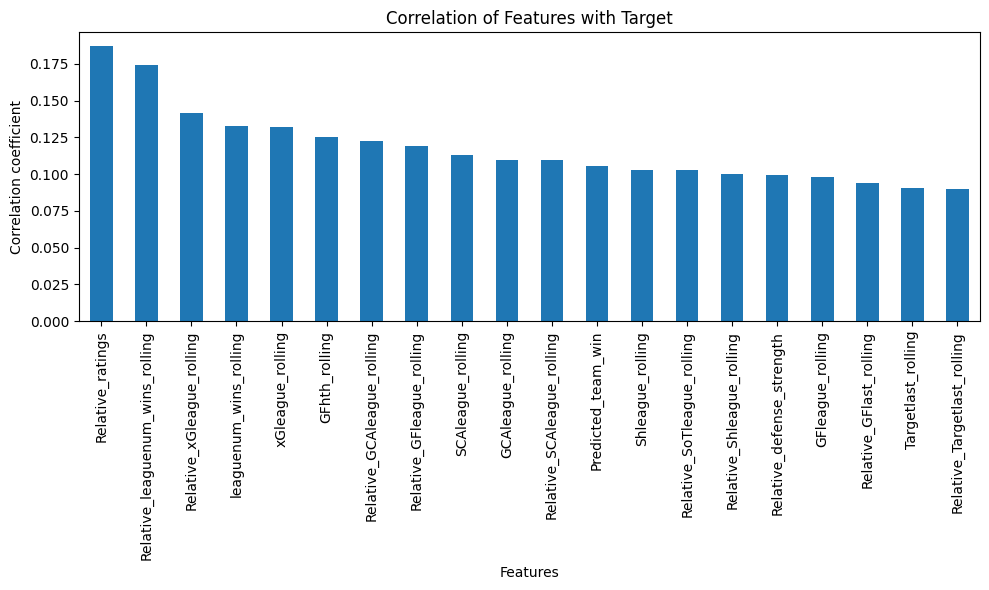

In [56]:
train = past_matches[past_matches['Season'] <= SEASON_SPLIT]
data = train.drop(columns=['Date', 'Target'])

# compute the correlation of features with Target
corr_with_target = data.corrwith(train['Target']).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
corr_with_target.head(20).plot(kind='bar')
plt.title("Correlation of Features with Target")
plt.ylabel("Correlation coefficient")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Creating models and training

In [90]:
predictors = ['Team_code', 'Opp_code', 'Venue_code', 'Hour', 'Day_code']
additional_predictors = ['rolling_rests_1', 'rolling_rests_3',
                           'leaguenum_wins_rolling']
predictors = predictors + league_ravg_new_cols + last_ravg_new_cols + hth_ravg_new_cols + additional_predictors
predictors = predictors + ['Opp_' + column for column in league_ravg_new_cols]
predictors = predictors + ['Opp_' + column for column in last_ravg_new_cols]
predictors = predictors + ['Opp_' + column for column in additional_predictors]
predictors = predictors + ['Relative_pos', 'hthnum_wins_rolling',
                           'Relative_rolling_rests_1', 'Relative_rolling_rests_3',
                           'Relative_leaguenum_wins_rolling', 'Relative_attack_strength',
                           'Relative_defense_strength', 'Predicted_team_win', 'Predicted_team_draw', 
                            'Predicted_team_loss', 'Relative_ratings',
                            'Expected_goal_team', 'Expected_goal_opp']
predictors = predictors + relative_cols

train = past_matches[past_matches['Season'] <= SEASON_SPLIT]
val = train[train['Date'] >= '2024-03-14']
train = train[train['Date'] < '2024-03-14']
test = past_matches[past_matches['Season'] > SEASON_SPLIT]
train_X = train[predictors]
val_X = val[predictors]
test_X = test[predictors]
train_Y = train['Target']
val_Y = val['Target']
test_Y = test['Target']

In [58]:
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': np.arange(100, 200, 5), 
    'min_samples_split': np.arange(2,10),
    'max_depth': np.arange(2,10)
}

tscv = TimeSeriesSplit(n_splits=5)

clf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
clf.fit(train_X, train_Y)
refined_rf_model = clf.best_estimator_
preds = refined_rf_model.predict(test_X)
print(clf.best_params_)
print(classification_report(test_Y, preds, zero_division=0))

{'max_depth': np.int64(9), 'min_samples_split': np.int64(7), 'n_estimators': np.int64(115)}
              precision    recall  f1-score   support

         0.0       0.25      0.05      0.08       109
         1.0       0.51      0.68      0.58       152
         2.0       0.52      0.64      0.57       161

    accuracy                           0.50       422
   macro avg       0.42      0.45      0.41       422
weighted avg       0.44      0.50      0.45       422



In [59]:
feature_importance = pd.Series(refined_rf_model.feature_importances_, index=train_X.columns).sort_values(ascending=False)
feature_importance

Relative_ratings              0.035932
Relative_pos                  0.022068
Relative_xGleague_rolling     0.014679
Flsleague_rolling             0.014342
Relative_rolling_rests_3      0.013147
                                ...   
PKlast_rolling                0.000687
Relative_2CrdYlast_rolling    0.000579
Opp_FKlast_rolling            0.000437
Opp_PKlast_rolling            0.000343
Opp_2CrdYlast_rolling         0.000306
Length: 163, dtype: float64

In [65]:
THRESHOLD = 0.009
selected_features = feature_importance[feature_importance >= THRESHOLD].index
print(len(selected_features))
train_X_selected = train_X[selected_features]
test_X_selected = test_X[selected_features]

28


In [63]:
result = permutation_importance(refined_rf_model, val_X, val_Y, n_repeats=10, random_state=42)

# Convert to DataFrame
importances_df = pd.DataFrame({
    "feature": val_X.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

non_zero_importances = importances_df[importances_df['importance_mean'] > 0.006]

print(non_zero_importances)

                         feature  importance_mean  importance_std
115             Relative_ratings         0.078218        0.031137
2                     Venue_code         0.024752        0.017849
108     Relative_rolling_rests_3         0.015842        0.011881
60         Opp_SoTleague_rolling         0.014851        0.004950
122  Relative_Distleague_rolling         0.012871        0.007733
68         Opp_Flsleague_rolling         0.010891        0.009341
106          hthnum_wins_rolling         0.009901        0.004428
80            Opp_GAlast_rolling         0.009901        0.007669
58          Opp_GAleague_rolling         0.009901        0.008856
20             Intleague_rolling         0.008911        0.002970
1                       Opp_code         0.008911        0.010337
132   Relative_Crsleague_rolling         0.007921        0.005941
31              Distlast_rolling         0.006931        0.004537
3                           Hour         0.006931        0.004537
57        

In [91]:
features = non_zero_importances['feature']
train_X_selected2 = train_X[features]
test_X_selected2 = test_X[features]

In [67]:
common_features = [feature for feature in features if feature in selected_features]
common_features

['Relative_ratings',
 'Venue_code',
 'Relative_rolling_rests_3',
 'Relative_Distleague_rolling',
 'Opp_Flsleague_rolling',
 'Opp_code',
 'Relative_Crsleague_rolling',
 'Relative_Distlast_rolling']

In [92]:
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X_selected)
test_X_scaled = scaler.transform(test_X_selected)
train_X_scaled2 = scaler.fit_transform(train_X_selected2)
test_X_scaled2 = scaler.transform(test_X_selected2)

In [69]:
normalized_sample_weights = compute_sample_weight(class_weight={0:2, 1:1, 2:1}, y=train_Y)
xgboost_model = XGBClassifier(random_state=42)
param_grid = {
    'eta': np.arange(0, 1, 0.1), 
    'max_depth': np.arange(1, 10),
    'alpha': np.arange(0, 10)
}

xgboost_clf = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
xgboost_clf.fit(train_X_scaled2, train_Y, sample_weight = normalized_sample_weights)
better_xgboost_model = xgboost_clf.best_estimator_
better_xgboost_preds = better_xgboost_model.predict(test_X_scaled2)
print(xgboost_clf.best_params_)
print(classification_report(test_Y, better_xgboost_preds, zero_division=0))

{'alpha': np.int64(0), 'eta': np.float64(0.4), 'max_depth': np.int64(9)}
              precision    recall  f1-score   support

         0.0       0.24      0.17      0.20       109
         1.0       0.52      0.56      0.54       152
         2.0       0.51      0.57      0.54       161

    accuracy                           0.46       422
   macro avg       0.42      0.43      0.43       422
weighted avg       0.44      0.46      0.45       422



In [73]:
svc_model = SVC(random_state=42, probability=True)
param_grid = {
    'C': np.arange(0.1, 1, 0.1), 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svc_clf = GridSearchCV(estimator=svc_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
svc_clf.fit(train_X_scaled2, train_Y, sample_weight = normalized_sample_weights)
better_svc_model = svc_clf.best_estimator_
better_svc_preds = better_svc_model.predict(test_X_scaled2)
print(svc_clf.best_params_)
print(classification_report(test_Y, better_svc_preds, zero_division=0))

{'C': np.float64(0.2), 'kernel': 'linear'}
              precision    recall  f1-score   support

         0.0       0.31      0.51      0.39       109
         1.0       0.64      0.47      0.54       152
         2.0       0.58      0.47      0.52       161

    accuracy                           0.48       422
   macro avg       0.51      0.48      0.48       422
weighted avg       0.53      0.48      0.49       422



In [75]:
lr_model = LogisticRegression(random_state=42, max_iter=100000000)
param_grid = {
    'C': np.arange(0.1, 1, 0.1), 
    'solver': ['saga', 'lbfgs', 'sag', 'newton-cg', 'newton-cholesky']
}

lr_clf = GridSearchCV(estimator=lr_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
lr_clf.fit(train_X_scaled2, train_Y, sample_weight=normalized_sample_weights)
better_lr_model = lr_clf.best_estimator_
better_lr_preds = better_lr_model.predict(test_X_scaled2)
print(lr_clf.best_params_)
print(classification_report(test_Y, better_lr_preds, zero_division=0))

{'C': np.float64(0.4), 'solver': 'saga'}
              precision    recall  f1-score   support

         0.0       0.29      0.45      0.35       109
         1.0       0.60      0.49      0.54       152
         2.0       0.58      0.46      0.51       161

    accuracy                           0.47       422
   macro avg       0.49      0.47      0.47       422
weighted avg       0.51      0.47      0.48       422



In [ ]:
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': np.arange(100, 200, 5), 
    'min_samples_split': np.arange(2,10),
    'max_depth': np.arange(2,10)
}

clf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
clf.fit(train_X_scaled2, train_Y, sample_weight = normalized_sample_weights)
better_rf_model = clf.best_estimator_
better_rf_preds = better_rf_model.predict(test_X_scaled2)
print(clf.best_params_)
print(classification_report(test_Y, better_rf_preds, zero_division=0))

{'max_depth': np.int64(5), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(180)}
              precision    recall  f1-score   support

         0.0       0.28      0.43      0.34       109
         1.0       0.59      0.47      0.52       152
         2.0       0.58      0.50      0.54       161

    accuracy                           0.47       422
   macro avg       0.49      0.47      0.47       422
weighted avg       0.51      0.47      0.48       422



In [77]:
base_estimators = [
    ('rf', RandomForestClassifier(random_state=42, n_estimators=100, min_samples_split=2, max_depth=5)),
    ('xgb', XGBClassifier(alpha=0, random_state=42, eta=0.4, max_depth=9)),
    ('svc', SVC(random_state=42, C=0.2, kernel='linear', probability=True)),
    ('lr', LogisticRegression(random_state=42, C=0.4, solver='saga', max_iter=10000000))
]

voter = VotingClassifier(estimators=base_estimators, voting='soft')

param_grid = {
    'weights': [(w1, w2, w3, w4) for w1 in range(1,5) for w2 in range(1,5) for w3 in range(1,5) for w4 in range(1,5)]
}

voting_clf = GridSearchCV(estimator=voter, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
voting_clf.fit(train_X_scaled2, train_Y, sample_weight=normalized_sample_weights)
refined_voting_model = voting_clf.best_estimator_
voter_preds = refined_voting_model.predict(test_X_scaled2)
voter_proba = refined_voting_model.predict_proba(test_X_scaled2)

print(voting_clf.best_params_)
print(classification_report(test_Y, voter_preds, zero_division=0))

{'weights': (4, 3, 1, 3)}
              precision    recall  f1-score   support

         0.0       0.26      0.22      0.24       109
         1.0       0.55      0.56      0.56       152
         2.0       0.55      0.60      0.57       161

    accuracy                           0.49       422
   macro avg       0.45      0.46      0.45       422
weighted avg       0.47      0.49      0.48       422



In [78]:
voter_proba = np.clip(voter_proba, 0, 1)
voter_proba = voter_proba / voter_proba.sum(axis=1, keepdims=True) 
logloss = log_loss(test_Y, voter_proba)
print("Log Loss:", logloss)

Log Loss: 1.0285533703363876


In [79]:
def multiclass_brier_score(y_true, y_proba):
    y_true = y_true.astype(int)
    n_samples, n_classes = y_proba.shape
    # one-hot encode y_true
    y_true_oh = np.zeros_like(y_proba)
    y_true_oh[np.arange(n_samples), y_true] = 1
    # mean squared error
    return np.mean(np.sum((y_proba - y_true_oh) ** 2, axis=1))

brier = multiclass_brier_score(test_Y, voter_proba)
print("Brier Score:", brier)

Brier Score: 0.6147544215607463


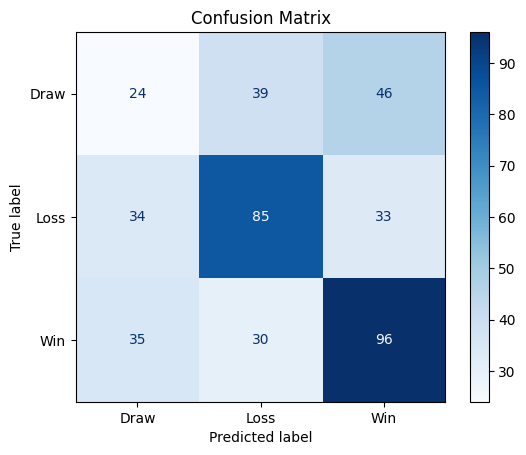

In [80]:
cm = confusion_matrix(test_Y, voter_preds, labels=[0,1,2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Draw", "Loss", "Win"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


## Predicting upcoming matches

In [95]:
predict_X = future_matches[features]
predict_X

,Relative_ratings,Venue_code,Relative_rolling_rests_3,Opp_SoTleague_rolling,Relative_Distleague_rolling,Opp_Flsleague_rolling,hthnum_wins_rolling,Opp_GAlast_rolling,Opp_GAleague_rolling,Intleague_rolling,Opp_code,Relative_Crsleague_rolling,Distlast_rolling,Hour,Opp_GFleague_rolling,Relative_Offleague_rolling,Relative_Distlast_rolling
2364,11.339011,1,1.000000,3.333333,5.700000,15.666667,1.0,2.0,1.333333,8.000000,22.0,-7.333333,26.7,18,1.666667,-0.333333,9.4
2365,103.335427,0,-2.333333,2.000000,2.366667,13.000000,0.0,6.0,2.333333,8.666667,23.0,8.000000,19.6,21,1.000000,-0.333333,5.5
2366,-213.469227,0,2.000000,7.666667,3.800000,8.666667,2.0,1.0,0.666667,4.000000,20.0,0.000000,18.3,16,2.333333,-1.333333,1.0
2368,75.298549,1,-2.333333,4.333333,-1.266667,13.666667,2.0,0.0,0.333333,9.000000,17.0,-1.000000,22.3,18,1.000000,0.000000,5.6
2369,-15.608148,0,0.333333,5.000000,-0.566667,7.666667,1.0,1.0,2.666667,7.333333,11.0,-7.000000,16.5,14,0.333333,1.333333,0.4
2374,-153.368066,1,2.333333,5.000000,-1.333333,14.333333,2.0,3.0,0.666667,5.333333,3.0,-3.666667,18.4,16,1.333333,-0.333333,-0.1
2375,-44.481938,1,0.333333,1.666667,-4.366667,11.000000,1.0,2.0,1.666667,10.333333,18.0,0.000000,19.8,18,0.333333,-1.333333,-4.7
2376,6.852485,0,0.333333,4.333333,-1.866667,12.000000,0.0,2.0,1.333333,7.333333,19.0,-3.000000,18.5,14,0.333333,-3.333333,-2.8
2379,218.751043,1,-2.000000,3.333333,-0.700000,14.333333,1.0,0.0,1.333333,7.000000,10.0,-0.666667,17.4,21,1.333333,-0.333333,-1.7
2382,NaN,1,NaN,NaN,NaN,NaN,2.0,NaN,NaN,8.000000,16.0,NaN,15.1,21,NaN,NaN,NaN


In [98]:
full_train_X = pd.concat([train_X_selected2, test_X_selected2])
full_train_Y = pd.concat([train_Y, test_Y])
normalized_sample_weights2 = compute_sample_weight(class_weight={0:2, 1:1, 2:1}, y=full_train_Y)

full_train_X_scaled = scaler.fit_transform(full_train_X)
future_matches_copy = future_matches[future_matches['Date'] < '2025-09-23']
predict_X = future_matches_copy[features]
predict_X_scaled = scaler.transform(predict_X)
# checking if any features have any NaN/null values
for feature, null_bool in predict_X.isnull().any().items():
    if null_bool: 
        print(feature)

refined_voting_model.fit(full_train_X_scaled, full_train_Y, sample_weight=normalized_sample_weights2)
voter_preds = refined_voting_model.predict(predict_X_scaled)
voter_proba = refined_voting_model.predict_proba(predict_X_scaled)
result_mapping_dict = {'0': 'Draw', '1': 'Loss', '2': 'Win'}
voter_preds = [result_mapping_dict.get(str(int(result))) for result in voter_preds]
team_mapping_dict2 = {value: key for key, value in team_mapping_dict.items()}
team_names = future_matches_copy['Team_code'].map(team_mapping_dict2)
opp_names = future_matches_copy['Opp_code'].map(team_mapping_dict2)
result = pd.DataFrame({'Date': future_matches_copy['Date'],
                       'Team_position': future_matches_copy['Team_position'],
                       'Team':team_names, 
                        'Pred':voter_preds, 'Opponent': opp_names,
                        'Opp_position': future_matches_copy['Opp_position'],
                        'Team_win%': voter_proba[:,2],
                        'Opp_win%': voter_proba[:,1],
                        'Draw%': voter_proba[:,0]})
for col in ['Team_win%', 'Opp_win%', 'Draw%']:
    result[col] = (result[col] * 100).round(2)
result

,Date,Team_position,Team,Pred,Opponent,Opp_position,Team_win%,Opp_win%,Draw%
2364,2025-09-20,7.0,Alavés,Draw,Sevilla,12.0,38.22,16.20,45.58
2365,2025-09-20,4.0,Athletic Club,Draw,Valencia,14.0,29.18,15.95,54.87
2366,2025-09-20,3.0,Espanyol,Loss,Real Madrid,1.0,6.09,81.41,12.50
2368,2025-09-20,6.0,Villarreal,Win,Osasuna,9.0,60.88,10.04,29.08
2369,2025-09-20,18.0,Levante,Loss,Girona,20.0,18.23,47.79,33.99
2374,2025-09-21,19.0,Mallorca,Loss,Atlético Madrid,10.0,8.36,68.36,23.29
2375,2025-09-21,8.0,Elche,Draw,Oviedo,16.0,25.30,31.11,43.60
2376,2025-09-21,15.0,Celta Vigo,Loss,Rayo Vallecano,13.0,28.49,40.36,31.16
2379,2025-09-21,2.0,Barcelona,Win,Getafe,5.0,66.79,6.00,27.21
